<a href="https://colab.research.google.com/github/YashDeshpande1771/Spatial-Analysis-of-Airbnb-Data/blob/master/Airbnb_Data_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()

Saving neighbourhoods.geojson to neighbourhoods.geojson


In [0]:
from google.colab import files
uploaded = files.upload()

Saving listings.csv to listings.csv


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#to make the interactive maps
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [0]:
listings = pd.read_csv("listings.csv", index_col= "id", low_memory=False)


In [0]:
listings = listings[["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "price","weekly_price", "monthly_price", "market", "neighbourhood", "latitude", "longitude"]]

In [0]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40125 entries, 109 to 40603848
Data columns (total 24 columns):
property_type                  40125 non-null object
accommodates                   40125 non-null int64
first_review                   31980 non-null object
review_scores_value            31419 non-null float64
review_scores_cleanliness      31450 non-null float64
review_scores_location         31426 non-null float64
review_scores_accuracy         31451 non-null float64
review_scores_communication    31450 non-null float64
review_scores_checkin          31431 non-null float64
review_scores_rating           31469 non-null float64
maximum_nights                 40125 non-null int64
listing_url                    40125 non-null object
host_is_superhost              39690 non-null object
host_about                     25247 non-null object
host_response_time             31931 non-null object
host_response_rate             31931 non-null object
street                         40

In [0]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))


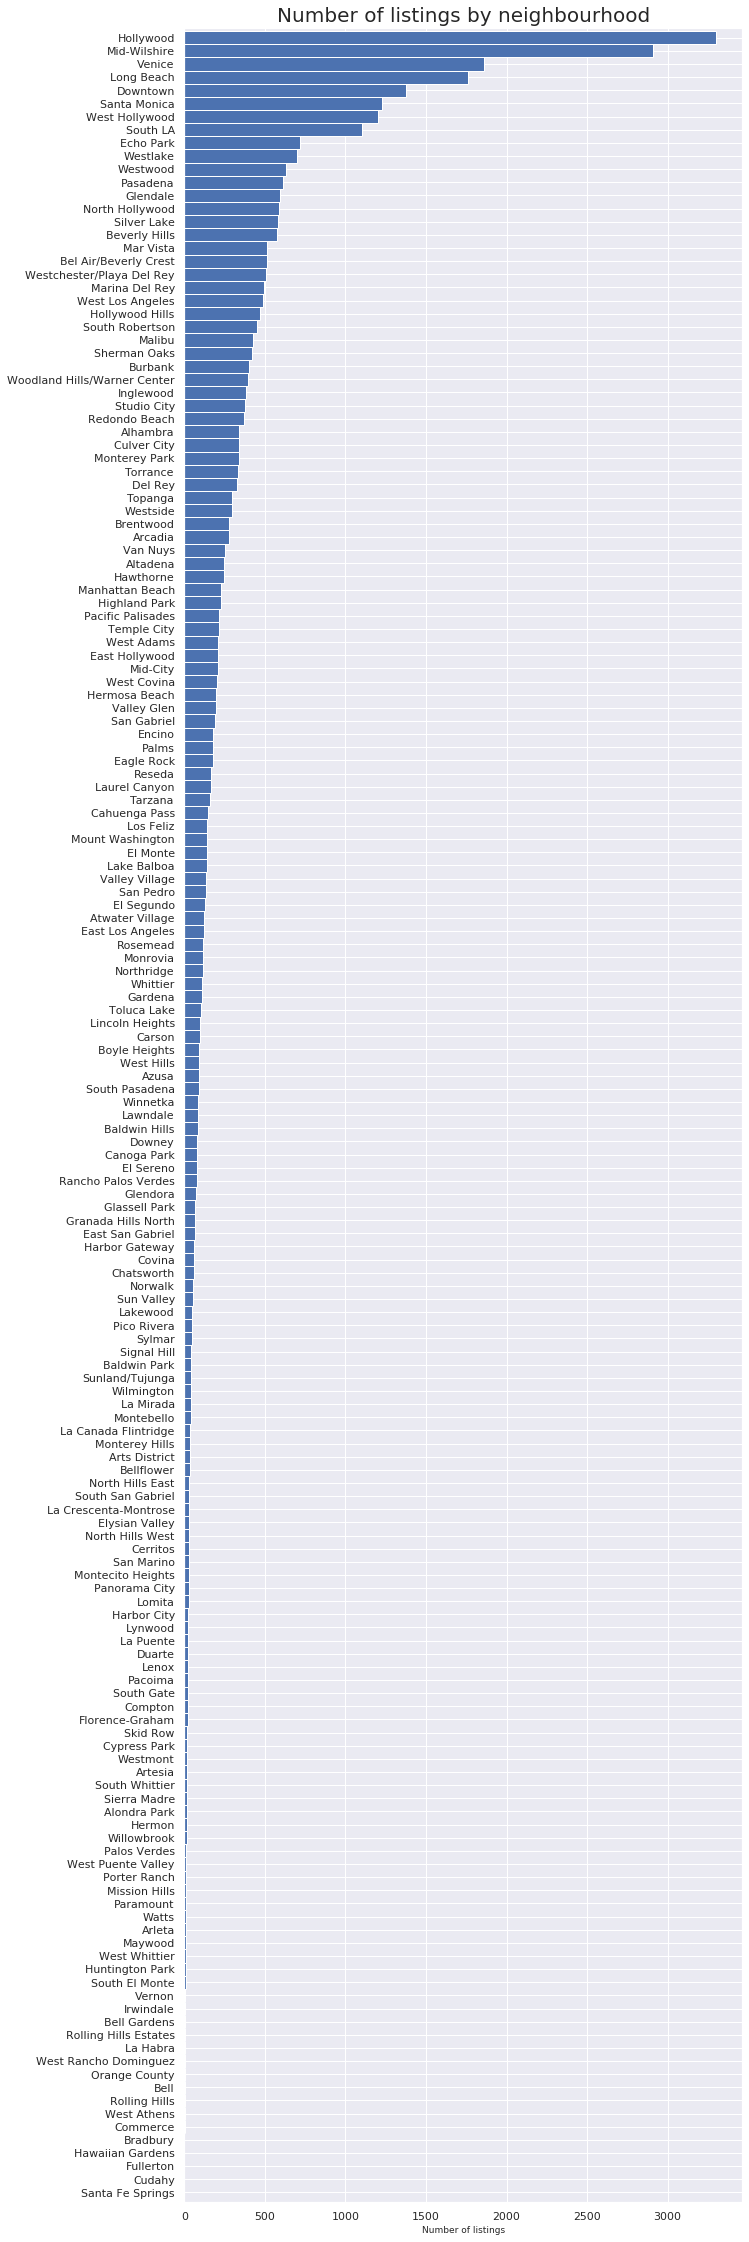

In [0]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 40), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize= 9)
plt.show()

In [0]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[34.0522, -118.2437], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

In [0]:
feq.shape

(165,)

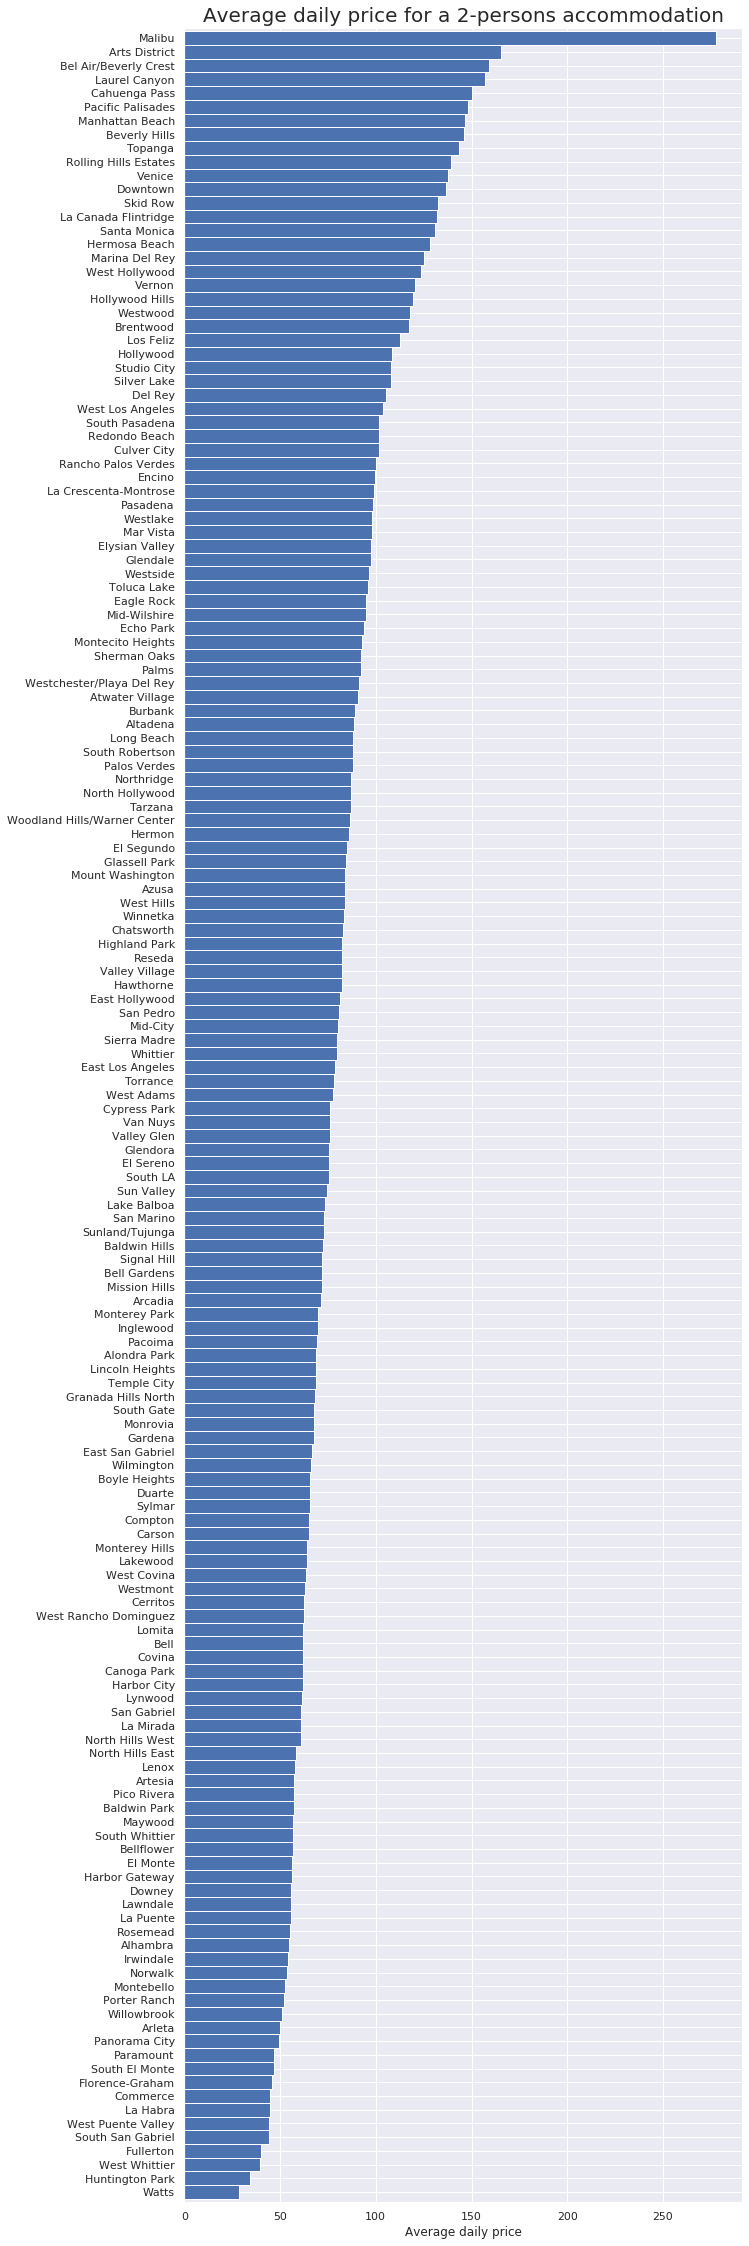

In [0]:
feq = listings[listings['accommodates']==2]
feq['price'] = feq['price'].str.lstrip("$")
feq['price'] = pd.to_numeric(feq['price'], errors='coerce')


feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 40), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price', fontsize=12)
plt.ylabel("")
plt.show()

In [0]:
feq = feq.rename_axis('neighbourhood').reset_index()


In [0]:
angel = gpd.read_file("neighbourhoods.geojson")


In [0]:
neigh_list = list(set(feq["neighbourhood"]))
ang = angel["neighbourhood"].isin(neigh_list) 


In [0]:
angel = pd.merge(angel, feq, on='neighbourhood', how='inner')
angel.rename(columns={'price': 'average_price'}, inplace=True)
angel.average_price = angel.average_price.round(decimals=0)

,neighbourhood,neighbourhood_group,geometry,average_price
0,Alondra Park,Unincorporated Areas,"MULTIPOLYGON (((-118.32651 33.89757, -118.3264...",69.0
1,Altadena,Unincorporated Areas,"MULTIPOLYGON (((-118.15135 34.21551, -118.1408...",89.0
2,East Los Angeles,Unincorporated Areas,"MULTIPOLYGON (((-118.17689 34.06228, -118.1730...",78.0
3,East San Gabriel,Unincorporated Areas,"MULTIPOLYGON (((-118.08229 34.10005, -118.0822...",67.0
4,La Crescenta-Montrose,Unincorporated Areas,"MULTIPOLYGON (((-118.23692 34.25212, -118.2216...",99.0
...,...,...,...,...
128,Watts,City of Los Angeles,"MULTIPOLYGON (((-118.24421 33.95378, -118.2442...",28.0
129,West Adams,City of Los Angeles,"MULTIPOLYGON (((-118.36859 34.03496, -118.3690...",78.0
130,West Hills,City of Los Angeles,"MULTIPOLYGON (((-118.60374 34.23323, -118.6029...",84.0
131,Whittier,Other Cities,"MULTIPOLYGON (((-118.06169 34.00487, -118.0613...",80.0


In [0]:
map_dict = angel.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[34.0522, -118.2437], zoom_start=11)
folium.GeoJson(data=angel,
               name='Los Angeles',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3